#### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.nn import GCNConv, GATConv, ChebConv,GATv2Conv, SAGEConv,global_max_pool
from torch_geometric.nn import knn_graph
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.stats import gaussian_kde

# Modeling

In [2]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x
    
    
class KNN_block(nn.Module):
    def __init__(self, in_channels):
        super(KNN_block, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(1568, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = F.relu(x)

#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = F.relu(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(x)

        x = 4 + 12 * x
        x = torch.round(x)

        return x
    
        
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p


class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn1 = SAGEConv(in_channels, hidden_channels)
        self.gcn2 = SAGEConv(64, 128)

    def forward(self, p4,knn_parameters):
        batch_size, num_channels, height, width = p4.size()

        # Reshape p4 to form node features for the graph
        x = p4.view(batch_size, num_channels, -1).permute(0, 2, 1)  # [batch_size, height*width, num_channels]

        # Create k-nearest neighbor graph
        graphs = []
        
        for i,g in enumerate(x):
            edge_index = knn_graph(g, k=int(knn_parameters[i]), loop=False)

            # Pass the node features through the GCN layer
            out = self.gcn1(g, edge_index)
            out = F.relu(out)
            out = self.gcn2(out, edge_index)
            out = F.relu(out)
            # Reshape back to the original shape

            graphs.append(out)
            
        graphs = torch.stack(graphs, dim=0)
        return graphs
    
    
        
class build_model(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(1, 16)
        self.e2 = encoder_block(16, 32)
        
        """ Graph Neural Network """
        self.knn_block = KNN_block(32)
        self.gcn_block = GCNModel(32, 64)
        
        
        """ Classifier """
        self.fc1 = nn.Linear(128, 64)
        self.outputs = nn.Linear(64, 26)
        
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)        
    
        """ Graph Neural Network """
        knn_parameters = self.knn_block(p2)
        if random.random() < 0.0001:
            print(knn_parameters)
        gcn_output = self.gcn_block(p2,knn_parameters)
        
        """ Graph Level Aggregation """
        node_size = gcn_output.shape[1]
        batch_tensor = torch.zeros(node_size,dtype=torch.int64)
        batch_tensor = batch_tensor.to(inputs.device)
        
        pooled = []
        for g in gcn_output:
            pooled_output = global_max_pool(g,batch_tensor)
            pooled.append(pooled_output)
            
        pooled = torch.stack(pooled, dim=0).reshape(-1,128)
        outputs = self.fc1(pooled)
        outputs = F.relu(outputs)
        outputs = self.outputs(outputs)

        return knn_parameters,outputs


# Data Reading and Preprocessing

In [3]:
total_knn_parameters = []


transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Set the root directory where the dataset will be downloaded (change this path accordingly)
data_root = './data'

# Define the EMNIST dataset for letters (use 'digits' instead of 'letters' for digits dataset)
emnist_dataset = datasets.EMNIST(root=data_root, split='letters', train=True, transform=transform, download=True)

# Separate the dataset into features (X) and labels (y)
X_train = []
y_train = []

for data in emnist_dataset:
    X_train.append(data[0].T.reshape(1, 28, 28).numpy())
    y_train.append(data[1])

# Convert to PyTorch tensors
X_train = torch.FloatTensor(np.array(X_train))
y_train = torch.LongTensor(np.array(y_train))

# Shuffle and split the dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8532\1291504209.py:19: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  X_train.append(data[0].T.reshape(1, 28, 28).numpy())


In [4]:
# Create DataLoader for training and validation sets
batch_size = 16
train_dataset = TensorDataset(X_train, y_train-1)
val_dataset = TensorDataset(X_val, y_val-1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the test dataset
emnist_test_dataset = datasets.EMNIST(root=data_root, split='letters', train=False, transform=transform, download=True)

# Separate the test dataset into features (X_test) and labels (y_test)
X_test = []
y_test = []

for data in emnist_test_dataset:
    X_test.append(data[0].T.reshape(1, 28, 28).numpy())
    y_test.append(data[1])

# Convert to PyTorch tensors
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

# Create DataLoader for the test set
test_dataset = TensorDataset(X_test, y_test-1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
def plot_images(images, labels, title):
    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"{title}: {labels[i].item()}",fontsize=12 if title == "Train Set" or title == "Test Set" else 9)
        plt.axis('off')
    plt.show()

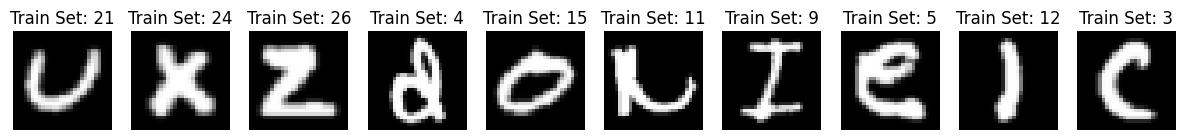

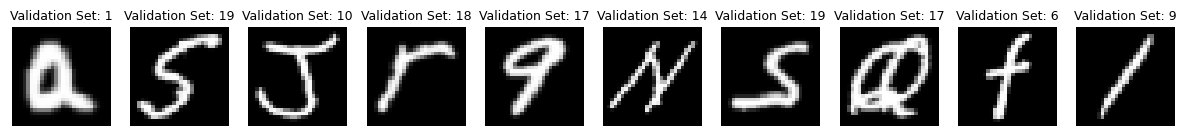

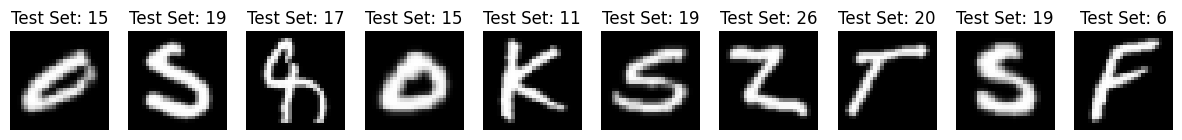

In [7]:
# Randomly select 10 samples from the train, validation, and test sets
np.random.seed(42)  # Set seed for reproducibility
train_samples_indices = np.random.choice(len(X_train), 10, replace=False)
val_samples_indices = np.random.choice(len(X_val), 10, replace=False)
test_samples_indices = np.random.choice(len(X_test), 10, replace=False)

# Extract samples and labels
train_samples = X_train[train_samples_indices]
train_labels = y_train[train_samples_indices]

val_samples = X_val[val_samples_indices]
val_labels = y_val[val_samples_indices]

test_samples = X_test[test_samples_indices]
test_labels = y_test[test_samples_indices]

# Plot samples
plot_images(train_samples, train_labels, "Train Set")
plot_images(val_samples, val_labels, "Validation Set")
plot_images(test_samples, test_labels, "Test Set")

# Model Training and Validation

In [8]:
# Initialize the model
model = build_model()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_metrics = []
val_metrics = []

# Training the model
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    knn_params = []
    y_train_pred = []
    y_train_true = []
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        knn_parameters, outputs = model(inputs)
        knn_params.append(knn_parameters)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
#         total_train += labels.size(0)
#         correct_train += (predicted == labels).sum().item()
        y_train_pred.extend(predicted.tolist())
        y_train_true.extend(labels.tolist())
    
    
    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    train_precision = precision_score(y_train_true, y_train_pred, average='macro')
    train_recall = recall_score(y_train_true, y_train_pred, average='macro')
    train_f1 = f1_score(y_train_true, y_train_pred, average='macro')
    
    total_knn_parameters.append(knn_params)
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    y_val_pred = []
    y_val_true = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            knn_parameters,outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
#             total_val += labels.size(0)
#             correct_val += (predicted == labels).sum().item()
            y_val_pred.extend(predicted.tolist())
            y_val_true.extend(labels.tolist())
        
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    val_precision = precision_score(y_val_true, y_val_pred, average='macro')
    val_recall = recall_score(y_val_true, y_val_pred, average='macro')
    val_f1 = f1_score(y_val_true, y_val_pred, average='macro')

    print(f"Epoch {epoch + 1}/{epochs} => "
          f"Train Loss: {train_loss / len(train_loader):.4f}, "
          f"Train Accuracy: {100 * train_accuracy:.2f}%, "
          f"Train Precision: {train_precision:.4f}, "
          f"Train Recall: {train_recall:.4f}%"
          f"Train F1: {train_f1:.4f}%, "
          f"Val loss: {val_loss / len(val_loader):.4f}%, "
          f"Val Accuracy: {100*val_accuracy:.4f}%, "
          f"Val Precision: {val_precision:.4f}%, "
          f"Val Recall: {val_recall:.4f}%, "
          f"Val F1: {val_f1:.4f}%")
    
    train_metrics.append([train_loss / len(train_loader),train_accuracy,train_precision,train_recall,train_f1])
    val_metrics.append([val_loss / len(val_loader),val_accuracy,val_precision,val_recall, val_f1])

tensor([[ 5.],
        [ 8.],
        [ 9.],
        [ 8.],
        [10.],
        [ 7.],
        [ 9.],
        [ 8.],
        [ 7.],
        [10.],
        [11.],
        [ 7.],
        [13.],
        [ 9.],
        [ 6.],
        [ 7.]], grad_fn=<RoundBackward0>)
tensor([[ 9.],
        [11.],
        [ 7.],
        [ 8.],
        [12.],
        [10.],
        [ 8.],
        [ 7.],
        [10.],
        [ 9.],
        [ 8.],
        [ 7.],
        [ 7.],
        [ 7.],
        [ 9.],
        [10.]], grad_fn=<RoundBackward0>)
Epoch 1/20 => Train Loss: 0.6081, Train Accuracy: 80.61%, Train Precision: 0.8058, Train Recall: 0.8060%Train F1: 0.8053%, Val loss: 0.3462%, Val Accuracy: 88.8141%, Val Precision: 0.8973%, Val Recall: 0.8869%, Val F1: 0.8858%
tensor([[12.],
        [ 8.],
        [ 9.],
        [ 9.],
        [ 7.],
        [ 6.],
        [11.],
        [ 8.],
        [ 7.],
        [ 8.],
        [11.],
        [11.],
        [ 7.],
        [11.],
        [ 7.],
        [ 9.]]

tensor([[6.],
        [6.],
        [7.],
        [6.],
        [5.],
        [7.],
        [5.],
        [5.],
        [7.],
        [6.],
        [6.],
        [5.],
        [7.],
        [5.],
        [6.],
        [5.]], grad_fn=<RoundBackward0>)
Epoch 18/20 => Train Loss: 0.1348, Train Accuracy: 95.12%, Train Precision: 0.9512, Train Recall: 0.9512%Train F1: 0.9512%, Val loss: 0.1704%, Val Accuracy: 93.9984%, Val Precision: 0.9423%, Val Recall: 0.9403%, Val F1: 0.9393%
Epoch 19/20 => Train Loss: 0.1326, Train Accuracy: 95.23%, Train Precision: 0.9523, Train Recall: 0.9523%Train F1: 0.9523%, Val loss: 0.1777%, Val Accuracy: 94.0785%, Val Precision: 0.9414%, Val Recall: 0.9407%, Val F1: 0.9408%
tensor([[6.],
        [5.],
        [7.],
        [5.],
        [7.],
        [5.],
        [6.],
        [7.],
        [6.],
        [5.],
        [6.],
        [6.],
        [6.],
        [6.],
        [5.],
        [5.]], grad_fn=<RoundBackward0>)
Epoch 20/20 => Train Loss: 0.1298, Train A

In [9]:
# Test the model
model.eval()
test_correct = 0
test_total = 0

y_test_pred = []
y_test_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        knn_parameters,outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
#         test_total += labels.size(0)
#         test_correct += (predicted == labels).sum().item()
        y_test_pred.extend(predicted.tolist())
        y_test_true.extend(labels.tolist())

test_accuracy = accuracy_score(y_test_true, y_test_pred)
test_precision = precision_score(y_test_true, y_test_pred, average='macro')
test_recall = recall_score(y_test_true, y_test_pred, average='macro')
test_f1 = f1_score(y_test_true, y_test_pred, average='macro')        
        
        
print(f"Test Accuracy: {100*test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f}%")
print(f"Test Recall: {test_recall:.4f}%")
print(f"Test F1: {test_f1:.4f}%")

Test Accuracy: 94.31%
Test Precision: 0.9441%
Test Recall: 0.9431%
Test F1: 0.9432%


In [10]:
train_loss = []
train_accuracy = []
train_precision = []
train_recall = []

val_loss = []
val_accuracy = []
val_precision = []
val_recall = []


epochs = [i+1 for i in range(len(train_metrics))]



for i in range(len(train_metrics)):
    
    train_loss.append(train_metrics[i][0])
    train_accuracy.append(train_metrics[i][1])
    train_precision.append(train_metrics[i][2])
    train_recall.append(train_metrics[i][3])
    
    
    val_loss.append(val_metrics[i][0])
    val_accuracy.append(val_metrics[i][1])
    val_precision.append(val_metrics[i][2])
    val_recall.append(val_metrics[i][3])

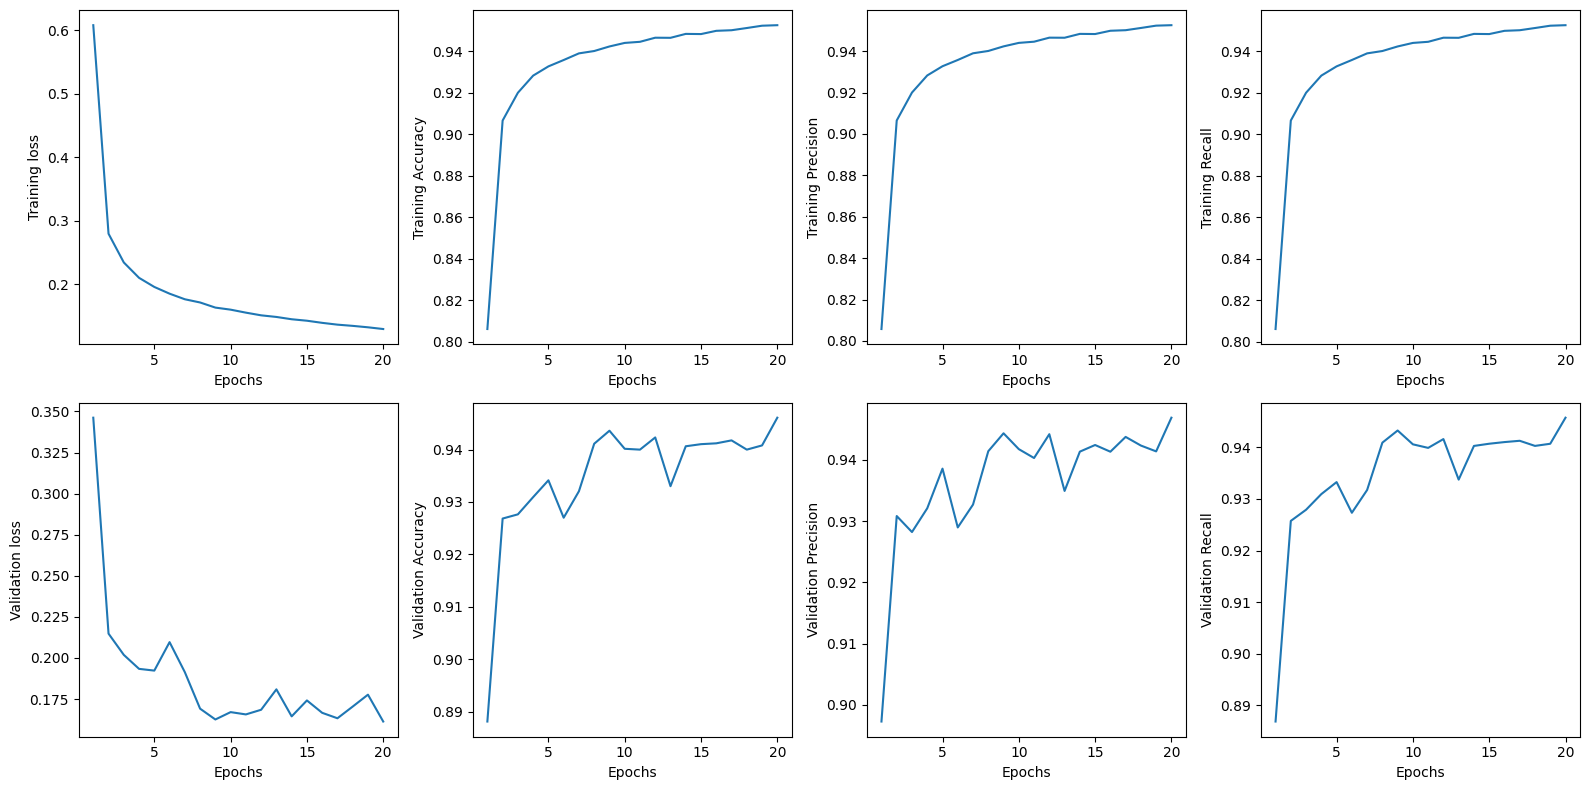

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns

# Example: Plotting something on each subplot

axs[0,0].plot(epochs,train_loss)
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Training loss")

axs[0,1].plot(epochs,train_accuracy)
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Training Accuracy")

axs[0,2].plot(epochs,train_precision)
axs[0,2].set_xlabel("Epochs")
axs[0,2].set_ylabel("Training Precision")

axs[0,3].plot(epochs,train_recall)
axs[0,3].set_xlabel("Epochs")
axs[0,3].set_ylabel("Training Recall")

axs[1,0].plot(epochs,val_loss)
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Validation loss")

axs[1,1].plot(epochs,val_accuracy)
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Validation Accuracy")

axs[1,2].plot(epochs,val_precision)
axs[1,2].set_xlabel("Epochs")
axs[1,2].set_ylabel("Validation Precision")

axs[1,3].plot(epochs,val_recall)
axs[1,3].set_xlabel("Epochs")
axs[1,3].set_ylabel("Validation Recall")




# Adjust layout
plt.tight_layout()
plt.show()

In [12]:
epoch_wise_dist = []

for e in total_knn_parameters:
    
    batch_wise_concat = np.array([])
    
    for b in e:
        batch_wise_concat = np.concatenate([batch_wise_concat,b.flatten().detach().numpy()],axis=0)
    
    epoch_wise_dist.append(batch_wise_concat)

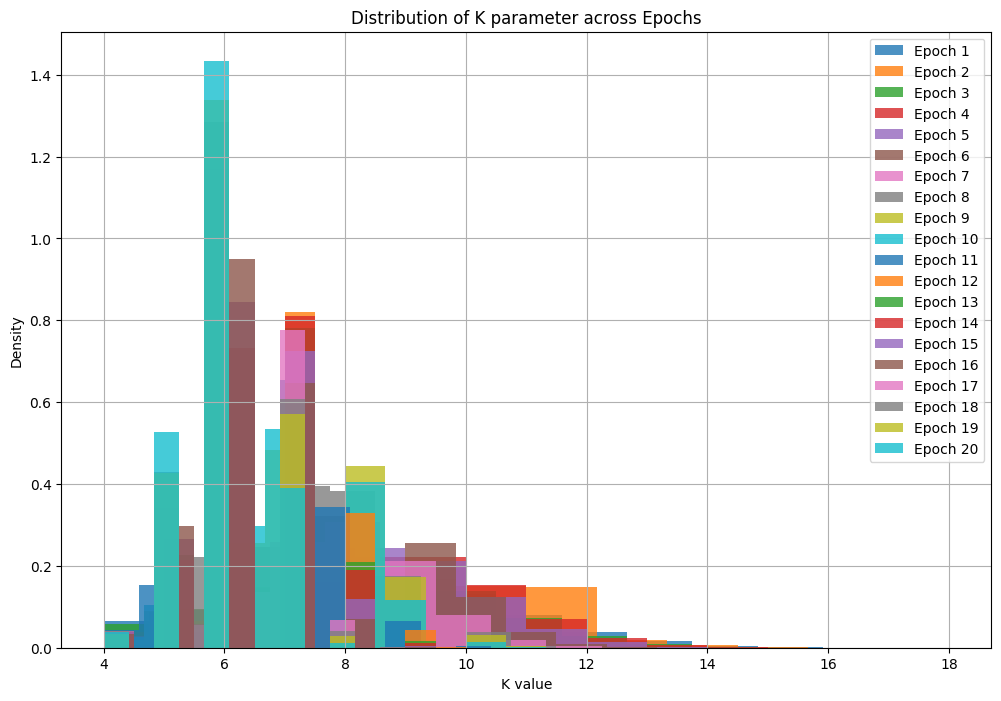

In [13]:
plt.figure(figsize=(12, 8))


for epoch, data in enumerate(epoch_wise_dist):
    plt.hist(data,density=True, bins=12, alpha=0.8, label=f'Epoch {epoch+1}')
    
    
plt.legend()
plt.title('Distribution of K parameter across Epochs')
plt.xlabel('K value')
plt.ylabel('Density')
plt.grid(True)
plt.show()